In [1]:
import os
#os.environ['R_HOME'] = '/home/h/hollenberg/miniconda3/envs/milopy-envv/lib/R' #path to your R installation
#os.environ['R_USER'] = '//home/h/hollenberg/miniconda3/envs/milopy-envv/lib/python3.11/site-packages/rpy2'
#home/h/hollenberg/miniconda3/envs/milopy-envv/bin/python
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging
import milopy
import milopy.core as milo
import milopy.plot as milopl
import milopy.utils

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
# path of partly preprocessed HLCA file used in this notebook:
adata_path = "/home/h/hollenberg/MaPra/datasets_seperate/peyser.h5ad"

# add annotation when not in adata -> None if annotation already in adata
#add_annotation = "/home/h/hollenberg/MaPra/datasets_seperate/galapagos_radiation_obs_annotation.csv"

sample_identifier = "batch" 
cell_type_identifier = "harmonized_anno" 
covariate_obs = "condition"


In [3]:
adata = sc.read(adata_path)
#if add_annotation is not None:
#    adata.obs = pd.read_csv(add_annotation)

In [14]:
adata 



AnnData object with n_obs × n_vars = 13454 × 23767
    obs: 'author_annotation', 'scDblFinder_score', 'scDblFinder_class', 'manual_celltype_annotation', 'batch', 'condition', 'doublet_score', 'predicted_doublet', 'timepoint', 'author_annotation_coarse', 'dataset', 'fibrotic/control', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'low_hierarchy', 'high_hierarchy', 'harmonized_anno', 'coarse_harmonized_anno', 'low_hierarchy_fine', 'high_hierarchy_fine', 'low_hierarchy_coarse', 'high_hierarchy_coarse', 'project', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance', 'condition_continuous'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total

In [4]:
d = 30
k = 50

sc.pp.neighbors(adata, n_neighbors=k, n_pcs=d)

In [5]:
milo.make_nhoods(adata, prop=0.1)
adata.obsm["nhoods"]
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

,nhood_ixs_refined,nhood_kth_distance
AAACCTGCATAACCTG-1_peyser,1,2.397161
AAACGGGGTAGAAGGA-1_peyser,1,1.229450
AACGTTGCACACAGAG-1_peyser,1,1.932498
AACTCAGCATGTAGTC-1_peyser,1,2.944524
AACTCTTCATTGTGCA-1_peyser,1,1.843539
...,...,...
TTAGGCAGTGCGAAAC-1_peyser,1,2.116790
TTAGTTCTCAGTCAGT-1_peyser,1,8.057677
TTCTCCTCAGACAAGC-1_peyser,1,1.341553
TTGAACGAGATCCGAG-1_peyser,1,7.125179


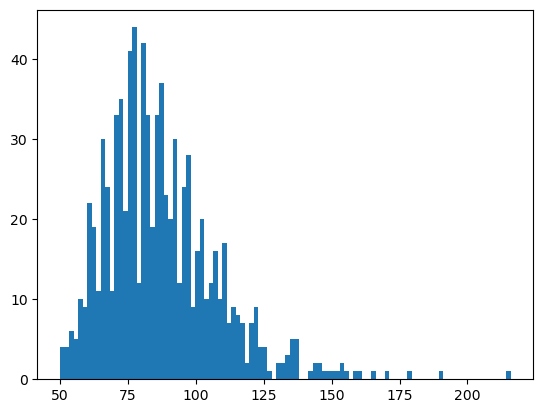

In [6]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

In [7]:
milo.count_nhoods(adata, sample_col=sample_identifier)
adata.uns["nhood_adata"]

AnnData object with n_obs × n_vars = 846 × 8
    obs: 'index_cell', 'kth_distance'
    uns: 'sample_col'

In [8]:
adata.obs["condition_continuous"] = adata.obs[covariate_obs].astype('category').cat.codes
milo.DA_nhoods(adata, design="~condition_continuous")

In [9]:
adata.uns["nhood_adata"].obs

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,AAACCTGCATAACCTG-1_peyser,2.397161,0.502978,10.498432,0.398313,0.539705,0.666555,0.706435
1,AAACGGGGTAGAAGGA-1_peyser,1.229450,0.162873,11.139336,0.011736,0.915500,0.945682,0.952049
2,AACGTTGCACACAGAG-1_peyser,1.932498,-0.078756,10.300046,0.007026,0.934587,0.959540,0.965274
3,AACTCAGCATGTAGTC-1_peyser,2.944524,0.186234,10.618134,0.067987,0.798655,0.868460,0.881509
4,AACTCTTCATTGTGCA-1_peyser,1.843539,1.481344,9.588529,1.635241,0.225311,0.361009,0.408651
...,...,...,...,...,...,...,...,...
841,TTAGGCAGTGCGAAAC-1_peyser,2.116790,7.771104,10.641546,8.614712,0.016771,0.058365,0.075324
842,TTAGTTCTCAGTCAGT-1_peyser,8.057677,0.163750,10.158738,0.047749,0.830664,0.888422,0.899595
843,TTCTCCTCAGACAAGC-1_peyser,1.341553,0.438169,10.359221,0.164937,0.691846,0.793092,0.823999
844,TTGAACGAGATCCGAG-1_peyser,7.125179,0.472057,9.902912,0.395059,0.541325,0.667581,0.706879


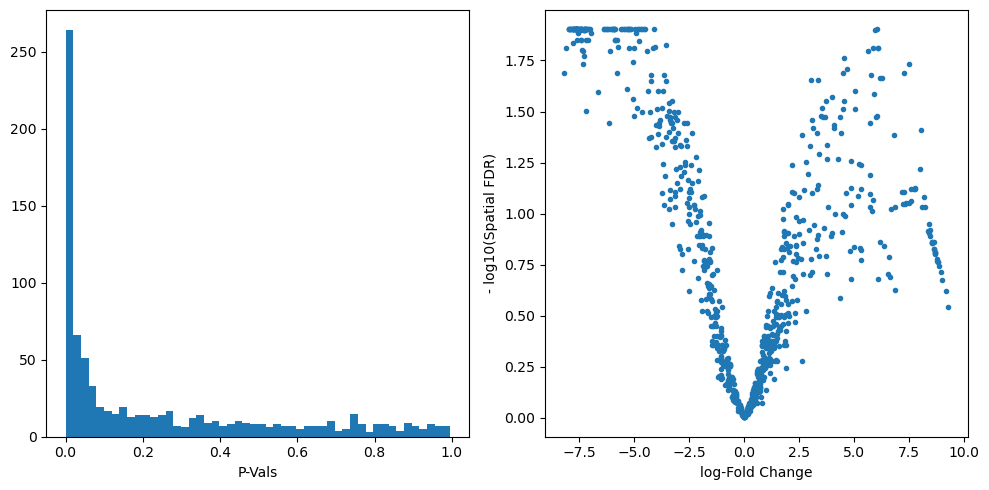

In [10]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [11]:
milopy.utils.build_nhood_graph(adata)

In [12]:
nhood_adata = adata.uns["nhood_adata"].copy()
nhood_adata

AnnData object with n_obs × n_vars = 846 × 8
    obs: 'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR', 'Nhood_size'
    var: 'condition_continuous', 'batch'
    uns: 'sample_col', 'nhood'
    obsm: 'X_milo_graph'
    obsp: 'nhood_connectivities'

StopIteration: 

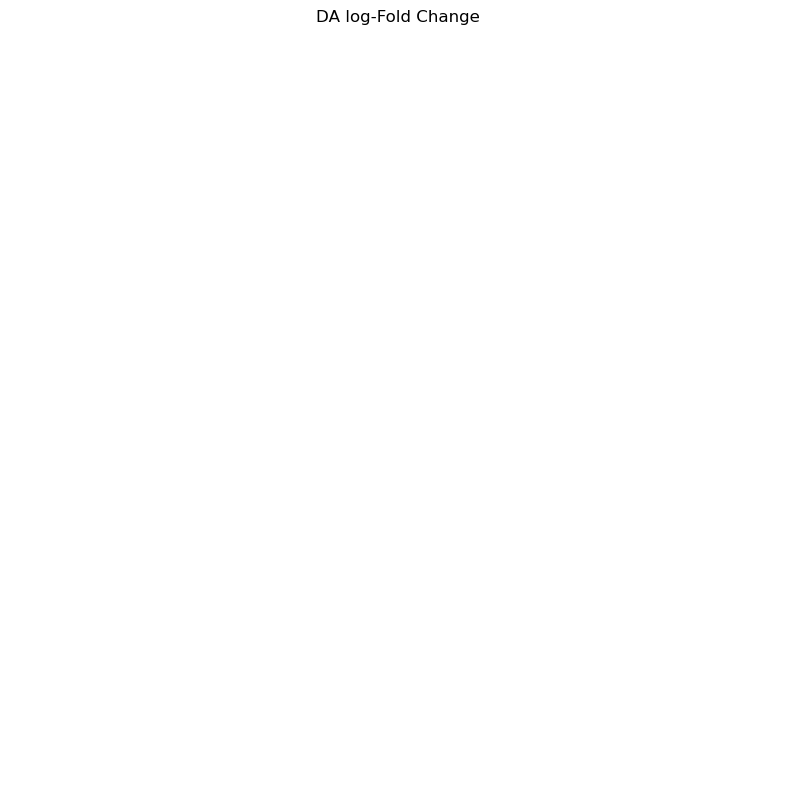

In [13]:
#import milopy.utils 
plt.rcParams["figure.figsize"] = [10,10]
milopl.plot_nhood_graph(adata,
    alpha=0.01, ## SpatialFDR level (1%)
    min_size=2 ## Size of smallest dot 
                       )

## Visualize result by celltype

In [20]:
milopy.utils.annotate_nhoods(adata, anno_col=cell_type_identifier)

ValueError: Must pass 2-d input. shape=()

In [ ]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

In [ ]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

In [ ]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()